# Sentiment Analysis - Text Classification with Universal Embeddings

### Adapted to tensorflow API (tf 2)

Textual data in spite of being highly unstructured, can be classified into two major types of documents.
- __Factual documents__ which typically depict some form of statements or facts with no specific feelings or emotion attached to them. These are also known as objective documents.
- __Subjective documents__ on the other hand have text which expresses feelings, mood, emotions and opinion.

Sentiment Analysis is also popularly known as opinion analysis or opinion mining. The key idea is to use techniques from text analytics, NLP, machine learning and linguistics to extract important information or data points from unstructured text. This in turn can help us derive the sentiment from text data

![](sentiment_cover.png)

Here we will be looking at building supervised sentiment analysis classification models thanks to the advantage of labeled data! The dataset we will be working with is the IMDB Large Movie Review Dataset having 50000 reviews classified into positive and negative sentiment. I have provided a compressed version of the dataset in this repository itself for your benefit!

Do remember that the focus here is not sentiment analysis but text classification by leveraging universal sentence embeddings.

![](sample_classification.png)

We will leverage the following sentence encoders here for demonstration from [TensorFlow Hub](https://tfhub.dev/):

- [__Neural-Net Language Model (nnlm-en-dim128)__](https://tfhub.dev/google/nnlm-en-dim128/1)
- [__Universal Sentence Encoder (universal-sentence-encoder)__](https://tfhub.dev/google/universal-sentence-encoder/2)


# Install Tensorflow Hub

In [ ]:
!pip install tensorflow-hub

# Load up Dependencies

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

# Check if GPU is available for use!

In [ ]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Load and View Dataset

In [ ]:
from google.colab import files
files.upload()

Saving movie_reviews.csv.bz2 to movie_reviews.csv.bz2


In [ ]:
dataset = pd.read_csv('movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
dataset['sentiment'] = [1 if sentiment == 'positive' else 0 for sentiment in dataset['sentiment'].values]
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Build train, validation and test datasets

In [ ]:
#reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = dataset[:30000]
train_sentiments = sentiments[:30000]

val_reviews = dataset[30000:35000]
val_sentiments = sentiments[30000:35000]

test_reviews = dataset[35000:]
test_sentiments = sentiments[35000:]
train_reviews.shape, val_reviews.shape, test_reviews.shape

((30000, 2), (5000, 2), (15000, 2))

# Basic Text Wrangling

In [ ]:
!pip install contractions
!pip install beautifulsoup4

     |████████████████████████████████| 284 kB 4.8 MB/s 
     |████████████████████████████████| 321 kB 41.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85432 sha256=78ad8ffa78e3d7200334273d31888facf4b1861448ed4cf8f944d13067083d89
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text):
    return contractions.fix(text)



def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def pre_process_document(document):

    # strip HTML
    document = strip_html_tags(document)

    # lower case
    document = document.lower()

    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))

    # remove accented characters
    document = remove_accented_chars(document)

    # expand contractions
    document = expand_contractions(document)

    # remove special characters and\or digits
    # insert spaces between special characters to isolate them
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)

    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()

    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [ ]:
train_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
# Apply a function to one column and assign it back to the column in dataframe
train_reviews['review'] = train_reviews['review'].apply(pre_process_corpus)

In [ ]:
train_reviews.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there is a family where a little boy...,0
4,petter matteis love in the time of money is a ...,1


In [ ]:
test_reviews['review'] = test_reviews['review'].apply(pre_process_corpus)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
val_reviews['review'] = val_reviews['review'].apply(pre_process_corpus)

# Build Data Ingestion Functions

In [ ]:

train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
      x=train_reviews,
      y=train_reviews['sentiment'],
      batch_size = 32,
      num_epochs = 5,
      shuffle = True,
      queue_capacity = 1000,
      num_threads = 1
  )


In [ ]:
# Prediction on the whole training set.
predict_train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_reviews, y=train_reviews['sentiment'], shuffle=False)

In [ ]:
#Prediction on the whole validation set.
predict_val_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=val_reviews, y=val_reviews['sentiment'], shuffle=False)

In [ ]:
# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=test_reviews, y=test_reviews['sentiment'], shuffle=False)

# Build Deep Learning Model with Universal Sentence Encoder

In [ ]:
embedding_feature = hub.text_embedding_column(
    key='review',
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

In [ ]:
dnn = tf.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=2,
          activation_fn=tf.nn.relu,
          dropout=0.1,
          optimizer=tf.optimizers.Adam(learning_rate=0.005))

# Model Training

In [ ]:
dnn.train(input_fn=train_input_fn)
print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))

Eval Metrics (Train): {'accuracy': 0.87476665, 'accuracy_baseline': 0.5005, 'auc': 0.9515034, 'auc_precision_recall': 0.95118713, 'average_loss': 0.2855348, 'label/mean': 0.5005, 'loss': 0.28549942, 'precision': 0.902014, 'prediction/mean': 0.47964254, 'recall': 0.84115887, 'global_step': 4688}
Eval Metrics (Validation): {'accuracy': 0.8592, 'accuracy_baseline': 0.505, 'auc': 0.9344688, 'auc_precision_recall': 0.9303857, 'average_loss': 0.3310572, 'label/mean': 0.495, 'loss': 0.33604774, 'precision': 0.87284213, 'prediction/mean': 0.4841747, 'recall': 0.83757573, 'global_step': 4688}


# Model Evaluation

In [ ]:
dnn.evaluate(input_fn=predict_train_input_fn)

{'accuracy': 0.87476665,
 'accuracy_baseline': 0.5005,
 'auc': 0.9515034,
 'auc_precision_recall': 0.95118713,
 'average_loss': 0.2855348,
 'global_step': 4688,
 'label/mean': 0.5005,
 'loss': 0.28549942,
 'precision': 0.902014,
 'prediction/mean': 0.47964254,
 'recall': 0.84115887}

In [ ]:
dnn.evaluate(input_fn=predict_train_input_fn)

{'accuracy': 0.87476665,
 'accuracy_baseline': 0.5005,
 'auc': 0.9515034,
 'auc_precision_recall': 0.95118713,
 'average_loss': 0.2855348,
 'global_step': 4688,
 'label/mean': 0.5005,
 'loss': 0.28549942,
 'precision': 0.902014,
 'prediction/mean': 0.47964254,
 'recall': 0.84115887}

In [ ]:
dnn.evaluate(input_fn=predict_test_input_fn)

{'accuracy': 0.85726666,
 'accuracy_baseline': 0.5006667,
 'auc': 0.93821406,
 'auc_precision_recall': 0.93751734,
 'average_loss': 0.32239187,
 'global_step': 4688,
 'label/mean': 0.5006667,
 'loss': 0.32232198,
 'precision': 0.8820265,
 'prediction/mean': 0.48099068,
 'recall': 0.8252996}

# Build a Generic Model Trainer on any Input Sentence Encoder

In [ ]:
import time

TOTAL_STEPS = 1500
STEP_SIZE = 500

my_checkpointing_config = tf.estimator.RunConfig(
    keep_checkpoint_max = 2,       # Retain the 2 most recent checkpoints.
)

def train_and_evaluate_with_sentence_encoder(hub_module, train_module=False, path=''):
    embedding_feature = hub.text_embedding_column(
        key='review', module_spec=hub_module, trainable=train_module)

    print()
    print('='*100)
    print('Training with', hub_module)
    print('Trainable is:', train_module)
    print('='*100)

    dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.optimizers.Adam(learning_rate=0.005),
            model_dir=path,
            config=my_checkpointing_config)

    #for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
      #  print('-'*100)
       # print('Training for step =', step)
       # start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
        #elapsed_time = time.time() - start_time
        #print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))

    train_eval_result = dnn.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = dnn.evaluate(input_fn=predict_test_input_fn)

    return {
      "Model Dir": dnn.model_dir,
      "Training Accuracy": train_eval_result["accuracy"],
      "Test Accuracy": test_eval_result["accuracy"],
      "Training AUC": train_eval_result["auc"],
      "Test AUC": test_eval_result["auc"],
      "Training Precision": train_eval_result["precision"],
      "Test Precision": test_eval_result["precision"],
      "Training Recall": train_eval_result["recall"],
      "Test Recall": test_eval_result["recall"]
    }

# Train Deep Learning Models on difference Sentence Encoders
- NNLM - pre-trained and fine-tuning
- USE - pre-trained and fine-tuning

In [ ]:
#tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

results = {}

results["nnlm-en-dim128"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", path='/storage/models/nnlm-en-dim128_f/')

results["nnlm-en-dim128-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/nnlm-en-dim128/1", train_module=True, path='/storage/models/nnlm-en-dim128_t/')

results["use-512"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", path='/storage/models/use-512_f/')

results["use-512-with-training"] = train_and_evaluate_with_sentence_encoder(
    "https://tfhub.dev/google/universal-sentence-encoder/2", train_module=True, path='/storage/models/use-512_t/')


Training with https://tfhub.dev/google/nnlm-en-dim128/1
Trainable is: False
Eval Metrics (Train): {'accuracy': 0.8229, 'accuracy_baseline': 0.5005, 'auc': 0.90358394, 'auc_precision_recall': 0.9050034, 'average_loss': 0.3956494, 'label/mean': 0.5005, 'loss': 0.39567196, 'precision': 0.8375783, 'prediction/mean': 0.48764482, 'recall': 0.8015984, 'global_step': 500}
Eval Metrics (Validation): {'accuracy': 0.8208, 'accuracy_baseline': 0.505, 'auc': 0.9008342, 'auc_precision_recall': 0.89806443, 'average_loss': 0.4007351, 'label/mean': 0.495, 'loss': 0.39419028, 'precision': 0.8288213, 'prediction/mean': 0.48934576, 'recall': 0.80404043, 'global_step': 500}

Training with https://tfhub.dev/google/nnlm-en-dim128/1
Trainable is: True
Eval Metrics (Train): {'accuracy': 0.8173, 'accuracy_baseline': 0.5005, 'auc': 0.89997196, 'auc_precision_recall': 0.9028918, 'average_loss': 0.40880138, 'label/mean': 0.5005, 'loss': 0.40872324, 'precision': 0.85036016, 'prediction/mean': 0.4583201, 'recall': 

# Model Evaluations

In [ ]:
results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

,Model Dir,Training Accuracy,Test Accuracy,Training AUC,Test AUC,Training Precision,Test Precision,Training Recall,Test Recall
nnlm-en-dim128,/storage/models/nnlm-en-dim128_f/,0.822900,0.822267,0.903584,0.903076,0.837578,0.835643,0.801598,0.802929
nnlm-en-dim128-with-training,/storage/models/nnlm-en-dim128_t/,0.817300,0.814000,0.899972,0.898082,0.850360,0.847059,0.770563,0.766977
use-512,/storage/models/use-512_f/,0.847533,0.845067,0.931448,0.929507,0.885248,0.881660,0.798934,0.797603
use-512-with-training,/storage/models/use-512_t/,0.849700,0.849600,0.932442,0.931138,0.879772,0.877877,0.810456,0.812650


In [ ]:
best_model_dir = results_df[results_df['Test Accuracy'] == results_df['Test Accuracy'].max()]['Model Dir'].values[0]
best_model_dir

'/storage/models/use-512_t/'

In [ ]:
embedding_feature = hub.text_embedding_column(
        key='review', module_spec="https://tfhub.dev/google/universal-sentence-encoder/2", trainable=True)

dnn = tf.estimator.DNNClassifier(
            hidden_units=[512, 128],
            feature_columns=[embedding_feature],
            n_classes=2,
            activation_fn=tf.nn.relu,
            dropout=0.1,
            optimizer=tf.optimizers.Adam(learning_rate=0.005),
            model_dir=best_model_dir)
dnn

In [ ]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

In [ ]:
predictions = get_predictions(estimator=dnn, input_fn=predict_test_input_fn)
predictions[:10]

[0, 1, 0, 1, 1, 0, 1, 1, 1, 1]

In [ ]:
!pip install seaborn

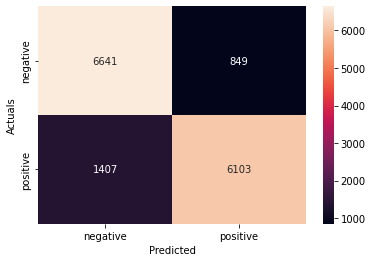

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.compat.v1.Session() as session:
    cm = tf.math.confusion_matrix(test_sentiments, predictions).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_sentiments, y_pred=predictions, target_names=LABELS))

              precision    recall  f1-score   support

    negative       0.83      0.89      0.85      7490
    positive       0.88      0.81      0.84      7510

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000

